# Further Research

Our previous points for further improving were:

1. Adding useful features to the data.
2. Experimenting with the classifers:    
    a. Using one user's classifier to predict another user's scores.    
    b. Try a different ML model.
3. Try aggregating entire dataset for learning and then predicting.
4. Better and faster interface for extracting the data once, and dynamicly choosing users to predict upon.

#### Imports

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Extracting dataset

In [1]:
from ReviewsData import *

In [3]:
N_USERS = 100
review_data = ReviewData(FILE_PATH, max_users=N_USERS)

2020-09-12 15:53:32,651 - DEBUG - Starting population of 100 user reviews from 7911684 reviews in file.
2020-09-12 16:01:36,015 - DEBUG - Populated data structure successfully.


In [4]:
users = review_data.get_users_list()
print(users)

['A141HP4LYPWMSR', 'A328S9RN3U5M68', 'A1I7QGUDP043DG', 'A1M5405JH9THP9', 'ATXL536YX71TR', 'A3QYDL5CDNYN66', 'AQJVNDW6YZFQS', 'AD4CDZK7D31XP', 'A3Q4S5DFVPB70D', 'A2P7UB02HAVEPB', 'A2TX99AZKDK0V7', 'AFC8IKR407HSK', 'A1FRPGQYQTAOR1', 'A1RSDE90N6RSZF', 'A1OUBOGB5970AO', 'A3NPHQVIY59Y0Y', 'AFKMBAY28XO8A', 'A66KMXH9V7OGU', 'AFJ27ZV9183B8', 'AXMKAXC0TR9AW', 'A34KFDQ5KBHZA5', 'A1CIW2OEVAJRM2', 'A1VJCDRXUQVXBM', 'A2IMLPUXYQJTSY', 'A1D12NAC1U12F0', 'A3RVH9HUN9J4LZ', 'AH7ZNGM8WOOGN', 'A2582KMXLK2P06', 'A1J50B4K22D93F', 'A2DLKD4AC5JV5Q', 'A8DDTUL8OWFMO', 'A174WE983H06N4', 'ASES4LU7WKYC', 'A3N27L13CWJ9HY', 'A2H5D7IK9SF07M', 'A2URPOBDQK3WG', 'A2TTVV34NLMZI8', 'A7LRQFZW3D9NE', 'A2R1VN4J5L2ZCO', 'A2I6MHMAZZDCRX', 'A3GX0UO7XXZST2', 'A2942G3FDOIM18', 'A11L5M4MJP00UW', 'A2VDM3D712BGLE', 'A1NN07FHTQZZ6K', 'A245OASCPKPJHC', 'AVQRC2N2SSSYS', 'A2ON9S58W4AZ1Z', 'A3IG9WGCIHPJ6X', 'A44YJ6ZLTMAR6', 'A27H9DOUGY9FOS', 'A39M64IZTC04G0', 'ATK3QFC6L1318', 'AWPODHOB4GFWL', 'A1R6DF0KOJ0TG6', 'A9Q28YTLYREO7', 'AVV8PPI6B

## Text cleaning tools

Removing punctuation & stopwords, tokenizing, and stemming.

In [31]:
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [32]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

## 1. Learning from certain user's data - with more features

In [22]:
user = users[0]
user_reviews = review_data.get_user_reviews(user)
data = pd.DataFrame.from_records(user_reviews)
# data = data.drop(columns=['productId', 'userId', 'profileName', 'helpfulness', 'time', 'summary'])
data

2020-09-12 20:01:21,508 - DEBUG - Starting search for user reviews.
2020-09-12 20:01:21,526 - DEBUG - Looking for user index.
2020-09-12 20:01:21,528 - DEBUG - Found user index: 0.
2020-09-12 20:01:21,529 - DEBUG - Returning user A141HP4LYPWMSR's  3649 reviews.


,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B000063W1R,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",3/3,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,6304286961,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",14/18,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5556167281,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",2/2,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,6303998690,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",9/10,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...,...,...,...,...
3644,B00008R9KP,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",0/0,5.0,1304553600,"""In The Eyes Of God, We Are All Equal"" ~ Waiti...",`Earth' is the second film in Deepa Mehta's ci...
3645,B0049MFTYM,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",4/4,5.0,1126483200,"""COME INTO ME!"" ~ Perceiving The Metaphysica...",What is it about this 1973 film dealing with t...
3646,6304960654,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",11/11,5.0,1128816000,"""The Story Maybe Apocraphal, But I Believe It""","Carl Kolchak, the Night Stalker! Truly one of ..."
3647,B000ROAK2W,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",9/20,3.0,1194912000,"""We Are One Smart Kid""",Disney's 'Meet the Robinson' is a fast paced a...


#### Converting to ourDataFrame

This time we use more features: the 'time' feature and the 'summary' feature.

In [24]:
data = pd.DataFrame.from_records(user_reviews)
data = data.drop(columns=['productId', 'userId', 'profileName', 'helpfulness'])
data

,score,time,summary,text
0,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...
3644,5.0,1304553600,"""In The Eyes Of God, We Are All Equal"" ~ Waiti...",`Earth' is the second film in Deepa Mehta's ci...
3645,5.0,1126483200,"""COME INTO ME!"" ~ Perceiving The Metaphysica...",What is it about this 1973 film dealing with t...
3646,5.0,1128816000,"""The Story Maybe Apocraphal, But I Believe It""","Carl Kolchak, the Night Stalker! Truly one of ..."
3647,3.0,1194912000,"""We Are One Smart Kid""",Disney's 'Meet the Robinson' is a fast paced a...


#### Split train/test

In [30]:
X = data[['time', 'summary', 'text']]
Y = data['score']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Vectorize text - using TF-IDF

In [37]:
vect_text = TfidfVectorizer(analyzer=clean_text)
vect_summary = TfidfVectorizer(analyzer=clean_text)

vect_fit_text = vect_text.fit(data['text'])
vect_fit_summary = vect_summary.fit(data['summary'])

train_text = vect_fit_text.transform(X_train['text'])
train_summary = vect_fit_summary.transform(X_train['summary'])

test_text = vect_fit_text.transform(X_test['text'])
test_summary = vect_fit_summary.transform(X_test['summary'])

X_train_vect = pd.concat([X_train[['time']].reset_index(drop=True), 
           pd.DataFrame(train_summary.toarray()), pd.DataFrame(train_text.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['time']].reset_index(drop=True), 
           pd.DataFrame(test_summary.toarray()), pd.DataFrame(test_text.toarray())], axis=1)

X_train_vect.head()

,time,0,1,2,3,4,5,6,7,8,...,12389,12390,12391,12392,12393,12394,12395,12396,12397,12398
0,1212278400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1135468800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1279929600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1124928000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1295481600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Classifying

In [39]:
logging.basicConfig(level=logging.WARNING)

We will use Random Forests.

In [41]:
def get_rf_model(X_train_vect, X_test_vect):
    rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)
    rf_model = rf.fit(X_train_vect, y_train)
    y_pred = rf_model.predict(X_test_vect)

    precision, recall, fscore, train_support = score(y_test, y_pred, labels=[1.0, 2.0, 3.0, 4.0, 5.0], average=None)
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        precision, recall, fscore, acs(y_test,y_pred)))

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    class_label = [1.0, 2.0, 3.0, 4.0, 5.0]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return rf_model

### Testing the results

C:\Users\dantc\anaconda3\envs\snap_env\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
2020-09-13 05:45:46,925 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E2C44D59E8>
2020-09-13 05:45:46,926 - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E2C44D59E8> on colorbar
2020-09-13 05:45:46,926 - DEBUG - Setting pcolormesh


Precision: [1.         1.         1.         0.9625     0.96103896] / Recall: [1.         0.96       0.96153846 0.9625     0.9833887 ] / F1-Score: [1.         0.97959184 0.98039216 0.9625     0.97208539] / Accuracy: 0.9712328767123287


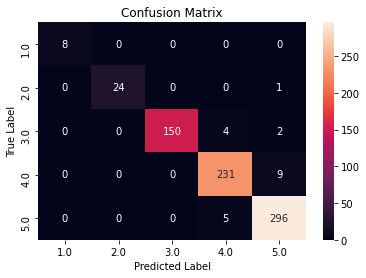

In [42]:
rf_model = get_rf_model(X_train_vect, X_test_vect)

Seems like a good classifier.

### Testing on a different user

In [43]:
user = users[1]
user_reviews = review_data.get_user_reviews(user)
data = pd.DataFrame.from_records(user_reviews)
# data = data.drop(columns=['productId', 'userId', 'profileName', 'helpfulness', 'time', 'summary'])
data

2020-09-13 05:50:00,859 - DEBUG - Starting search for user reviews.
2020-09-13 05:50:00,862 - DEBUG - Looking for user index.
2020-09-13 05:50:00,862 - DEBUG - Found user index: 1.
2020-09-13 05:50:00,863 - DEBUG - Returning user A328S9RN3U5M68's  7448 reviews.


,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
1,B000063W1R,A328S9RN3U5M68,Grady Harp,104/110,5.0,1031875200,A surprisingly fresh and superb adventure film,In this time of fire and explosion oriented bl...
2,B0001G6PZC,A328S9RN3U5M68,Grady Harp,2/2,5.0,1083888000,Surprisingly Fine Movie!,THE LAST SAMURAI is for many of us a Sleeper o...
3,B00022VM5I,A328S9RN3U5M68,Grady Harp,16/20,5.0,1068163200,A Brilliant Film That Stands On Its Own Merits,"Yes, Phillip Roth's gaudily angry masterwork o..."
4,B00022VM5I,A328S9RN3U5M68,Grady Harp,0/0,5.0,1090540800,Even More Intimate on DVD,THE HUMAN STAIN met a mixed reaction when rele...
...,...,...,...,...,...,...,...,...
7443,B002ZRX9GI,A328S9RN3U5M68,Grady Harp,3/3,5.0,1311811200,Creation of a Steinway: The Love between Creat...,NOTE BY NOTE is a documentary that is not a do...
7444,B001DSNEJW,A328S9RN3U5M68,Grady Harp,1/1,3.0,1290384000,This Film Slipped Under the Line Watch...,"One wonders when Cuba Gooding, Jr is going to ..."
7445,B008BTOY5Y,A328S9RN3U5M68,Grady Harp,11/13,4.0,1339891200,A Labyrinth of Questions of Fantasy and Reality,Douglas Kennedy's perplexing novel THE WOMAN I...
7446,B001NOMOT2,A328S9RN3U5M68,Grady Harp,66/71,5.0,1224460800,A Virtuosic Mind Twister of a Film,TELL NO ONE (Ne le dis &agrave; personne) succ...


C:\Users\dantc\anaconda3\envs\snap_env\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
2020-09-13 05:54:30,074 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E364182F28>


Precision: [1.         1.         1.         0.92035398 0.95503597] / Recall: [1.         0.83333333 0.89732143 0.9614792  0.95848375] / F1-Score: [1.         0.90909091 0.94588235 0.94046722 0.95675676] / Accuracy: 0.946979865771812


2020-09-13 05:54:30,080 - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E364182F28> on colorbar
2020-09-13 05:54:30,081 - DEBUG - Setting pcolormesh


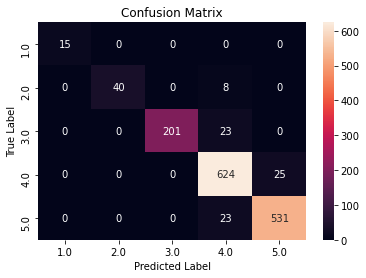

In [44]:
X = data[['time', 'summary', 'text']]
Y = data['score']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


vect_text = TfidfVectorizer(analyzer=clean_text)
vect_summary = TfidfVectorizer(analyzer=clean_text)

vect_fit_text = vect_text.fit(data['text'])
vect_fit_summary = vect_summary.fit(data['summary'])

train_text = vect_fit_text.transform(X_train['text'])
train_summary = vect_fit_summary.transform(X_train['summary'])

test_text = vect_fit_text.transform(X_test['text'])
test_summary = vect_fit_summary.transform(X_test['summary'])

X_train_vect = pd.concat([X_train[['time']].reset_index(drop=True), 
           pd.DataFrame(train_summary.toarray()), pd.DataFrame(train_text.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['time']].reset_index(drop=True), 
           pd.DataFrame(test_summary.toarray()), pd.DataFrame(test_text.toarray())], axis=1)

# X_train_vect.head()

logging.basicConfig(level=logging.WARNING)

rf_model = get_rf_model(X_train_vect, X_test_vect)